Implementation of mnist entirely in numpy following this guide https://www.kaggle.com/code/scaomath/simple-neural-network-for-mnist-numpy-from-scratch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#0-255 -> 0-1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

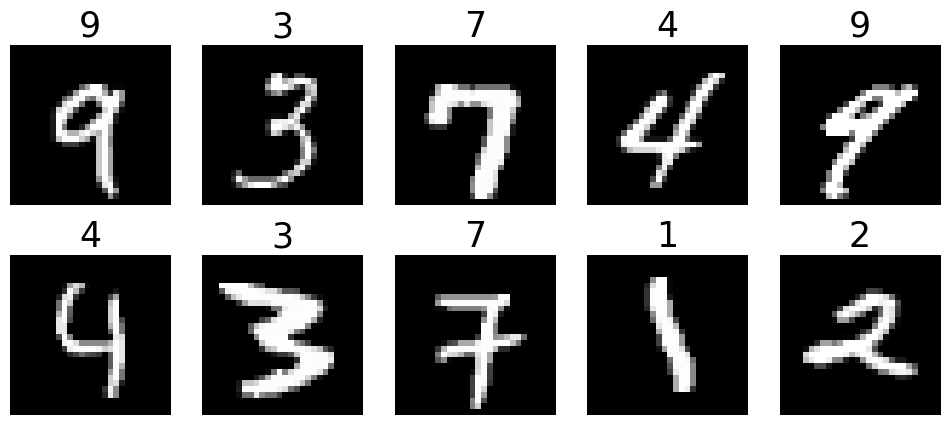

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
idx = np.random.randint(0, X_train.shape[0], size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i], :], cmap='gray')
    axes[i].axis('off')  # Hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color='black', fontsize=25)
plt.show()

In [ ]:
#flatten to (num_samples, 28*28 = 784)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
def relu(x):
  x[x<0] = 0 #creates boolean mask for negative values, sets those to 0
  return x

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
def model(X, W, b):
  '''
  used for inference since we do not perform grad descent
  '''
  #layer 1 - input; (batch_size, 784) * (784, 256) = (batch_size, 256)
  a1 = X
  z1 = np.matmul(a1, W[0]) + b[0]

  #layer 2 - hidden layer; (batch_size, 256) * (256, 10) -> (batch_size, 10)
  a2 = relu(z1) #a2 is (batch_size, 256)
  z2 = np.matmul(a2, W[1]) #no need for bias since softmax is scale invariant aka constants don't matter

  #compute softmax
  s = np.exp(z2) #(batch_size, 10)
  total = np.sum(s, axis=1).reshape(-1, 1) #(batch_size, 10) -> (batch_size, ) -> (batch_size, 1)
  sigma = s/total #(batch_size, 10)

  return sigma

In [ ]:
def softmax(X_in, weights):
  s = np.exp(np.matmul(X_in,weights))
  total = np.sum(s, axis=1).reshape(-1,1)
  return s / total

In [ ]:
def loss(y_pred, y_true):
  global K #number of classes

  K = 10
  N = len(y_true)

  #implement cross entropy loss with regularization
  y_true_one_hot = (y_true[:, np.newaxis] == np.arange(K)) #truthy only in the value that y_true is true -> (batch_size, 10)
  loss_sample = (np.log(y_pred) * y_true_one_hot).sum(axis=1) #CE, log(p_k) where k is the label, first goes (batch_size, 10) -> (batch_size, )
  return -np.mean(loss_sample) #computes mean across batch_size (only dim)

In [ ]:
def backprop(W, b, X, y, alpha=1.4):
  '''
  dJ/dz^2_k = (\sigma_k - 1) * 1(y=k) - this is training mode
  '''
  K=10
  N=X.shape[0]

  #input layer
  a1=X
  z1 = np.matmul(X, W[0]) + b[0]

  #layer 2
  a2 = relu(z1)
  z2 = np.matmul(a2, W[1])

  #compute softmax
  s = np.exp(z2)
  total = np.sum(s, axis=1).reshape(-1, 1)
  sigma = s/total #(batch_size, 10)

  #Compute gradients
  #layer 2 gradients
  y_one_hot_vec = (y[:, np.newaxis] == np.arange(K)) #(batch_size, 10)
  delta2=(sigma-y_one_hot_vec) #this is dJ/dz^2 = sigma - 1 where y=k
  grad_W1 = np.matmul(a2.T, delta2) #(batch_size, 256).T -> (256, batch_size) * (batch_size, 10) = (256, 10)

  #layer 1 gradients
  delta1=np.matmul(delta2, W[1].T) * (z1>0)
  grad_W0=np.matmul(X.T,delta1)

  dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
  db = [np.mean(delta1, axis=0)]

  return dW, db

In [ ]:
eta = 5e-1
alpha = 1e-6 #regularization
gamma = 0.99 #RMSprop
eps = 1e-3 #RMSprop
num_iter = 1000
n_H = 256
n = X_train.shape[1]
K = 10

In [ ]:
np.random.seed(1127825)
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H)]

In [ ]:
%%time
gW0 = gW1 = gb0 = 1

for i in range(num_iter):
  dW, db = backprop(W, b, X_train, y_train, alpha)

  gW0 = gamma*gW0 + (1-gamma) * np.sum(dW[0]**2)
  etaW0 = eta/np.sqrt(gW0+eps)
  W[0] -= etaW0*dW[0]

  gW1 = gamma*gW1 + (1-gamma) * np.sum(dW[1]**2)
  etaW1 = eta/np.sqrt(gW1+eps)
  W[1] -= etaW1*dW[1]

  gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
  etab0 = eta/np.sqrt(gb0 + eps)
  b[0] -= etab0 * db[0]

  if i % 500 == 0:
    #sanity check 1
    y_pred = model(X_train,W,b)
    print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(
          loss(y_pred,y_train)))
    print("Training accuracy after", i+1, "iterations is {:.4%}".format(
          np.mean(np.argmax(y_pred, axis=1)== y_train)))

    #sanity check 2
    print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
          .format(gW0, gW1, gb0, etaW0, etaW1, etab0))

    #sanity check 3
    print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}"
          .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")

    gW0 = gW1 = gb0 = 1

y_pred_final = model(X_train,W,b)
print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final,y_train)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_train)))

Cross-entropy loss after 1 iterations is 0.6764228
Training accuracy after 1 iterations is 83.3550%
gW0=0.9973 gW1=0.9975 gb0=0.9902
etaW0=0.5004 etaW1=0.5004 etab0=0.5022
|dW0|=0.85699 |dW1|=0.86327 |db0|=0.13833 

Cross-entropy loss after 501 iterations is 0.079010205
Training accuracy after 501 iterations is 97.8083%
gW0=0.0985 gW1=0.0400 gb0=0.0088
etaW0=1.5850 etaW1=2.4704 etab0=5.0538
|dW0|=0.01128 |dW1|=0.00603 |db0|=0.00094 

